In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/morph/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
from jax import jit, value_and_grad, vmap
import numpy as onp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle as p
import time as t

In [3]:
import poppy
import astropy.units as u

In [4]:
import equinox as eqx

---

# High Level Notes and Ideas

- Diffability tester function for custom ParamLayers
> We could write this by testing if gradients that are given by taking a least squares residual between two input values are non-zero.
> There are some cases where the gradients at that point are exactly zero by chance, but this is quite unlikely and we could try this over a series of randomly generated values within the parameter bounds in order to reduce the probability of this occuring. The idea is this could help people not used to working with auto-diff catch their errors before passing it into a big optical system.


---
# Base Classes

In [5]:
# Base Classes
class Layer(eqx.Module):
    size_in: int
    size_out: int
    
    def __init__(self, size_in, size_out, function):
        self.size_in = size_in
        self.size_out = size_out
        
        if function is not None:
            self.__call__ = function

        

class OpticalSystem(eqx.Module):
    """
    Base class defining some optical system
    layers must be a list of Layer objects
    Each layer object can either be some optical operation, 
    transform, or NN type layer
    """
    layers: list 
    
    def __init__(self, layers):
        self.layers = layers 
        
    def propagate_mono(self, params_dict):
        """
        Propagates a single wavelength of multiple layers
        This function will be vmapped over wavelength
        TO DO
        """
        wavefront = create_wavefront(Mosys.layers[0].size_in)

        for i in range(len(Mosys.layers)):
            layer = Mosys.layers[i]
            print(layer)
            if i in params_dict.keys():
                wavefront = layer(wavefront, params_dict[i])
            else:
                wavefront = layer(wavefront)
        return np.abs(wavefront)**2

    def propagate_mult(self):
        """
        Propagates multiple wavefronts for each star
        This function will be vmapped over stellar inputs
        TO DO
        """
        pass
    
    def propagate(self):
        """
        This function propagates multiple wavelengths and stars
        This function will be vmapped in two dimensions, wavelength and stars
        TO DO
        """
        pass
    


---

## Layer Sub-Classes


### - Transformation Layers

Layers that perform optical proagation opertaions

In [6]:
class FFT(Layer):
    """
    Layer to propagate an input array with an FFT
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
        
    def __call__(self, array):
        """
        Performs the FFT
        Normalisation, shifiting and sign convention matches poppy
        """
        norm = array.shape[0]
        array_out = norm * np.fft.fftshift( np.fft.ifft2(array) )
        return array_out 
    
class IFFT(Layer):
    """
    Layer to propagate an input array with an IFFT
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
        
    def __call__(self, array):
        """
        Performs the IFFT
        Normalisation, shifiting and sign convention matches poppy
        """
        norm = 1./array.shape[0]
        array_out = norm * np.fft.fft2( np.fft.ifftshift(array) )
        return array_out 

# class MFT(Layer):
#     """
#     Layer to perform the Matrix Fourier Transform
    
#     """
#     def __init__(self, size_in, size_out):
#         self.size_in = size_in
#         self.size_out = size_out
        
#     def __call__(self, wavefront, nlamD):
#         """
#         Should we add offset here too?
#         I have removed it but we have the code needed in the old notebooks
#         """        
#         npup, npix = self.size_in, self.size_out
#         dX = 1.0 / float(npup)
#         dU = nlamD / float(npix)
#         Xs = (np.arange(npup, dtype=float) - float(npup) / 2.0 + 0.5) * dX
#         Us = (np.arange(npix, dtype=float) - float(npix) / 2.0 + 0.5) * dU
#         XU = np.outer(Xs, Us)
#         expXU = np.exp(-2.0 * np.pi * 1j * XU)

#         # Note: Can casue overflow issues on 32-bit
#         norm_coeff = np.sqrt((nlamD**2) / (npup**2 * npix**2)) 

#         # Perform MFT
#         t1 = np.dot(expXU.T, wavefront)
#         t2 = np.dot(t1, expXU)
#         return norm_coeff * t2

class MFT(Layer):
    """
    Layer to perform the Matrix Fourier Transform
    
    """
    wavel_scale: float
    
    def __init__(self, size_in, size_out, wavel_scale):
        self.size_in = size_in
        self.size_out = size_out
        self.wavel_scale = wavel_scale
        
    def __call__(self, wavefront, wavel):
        """
        Should we add offset here too?
        I have removed it but we have the code needed in the old notebooks
        """        
        npup, npix = self.size_in, self.size_out
        nlamD = self.wavel_scale / wavel
        dX = 1.0 / float(npup)
        dU = nlamD / float(npix)
        Xs = (np.arange(npup, dtype=float) - float(npup) / 2.0 + 0.5) * dX
        Us = (np.arange(npix, dtype=float) - float(npix) / 2.0 + 0.5) * dU
        XU = np.outer(Xs, Us)
        expXU = np.exp(-2.0 * np.pi * 1j * XU)

        # Note: Can casue overflow issues on 32-bit
        norm_coeff = np.sqrt((nlamD**2) / (npup**2 * npix**2)) 

        # Perform MFT
        t1 = np.dot(expXU.T, wavefront)
        t2 = np.dot(t1, expXU)
        return norm_coeff * t2
        
class IMFT(Layer):
    """
    Layer to perform the Inverse Matrix Fourier Transform
    
    """
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out
        
    def __call__(self, wavefront, nlamD):
        """
        Should we add offset here too?
        I have removed it but we have the code needed in the old notebooks
        """        
        npup, npix = self.size_in, self.size_out
        dX = 1.0 / float(npup)
        dU = nlamD / float(npix)
        Xs = (np.arange(npup, dtype=float) - float(npup) / 2.0 + 0.5) * dX
        Us = (np.arange(npix, dtype=float) - float(npix) / 2.0 + 0.5) * dU
        XU = np.outer(Xs, Us)
        expXU = np.exp(2.0 * np.pi * 1j * XU)

        # Note: Can casue overflow issues on 32-bit
        norm_coeff = np.sqrt((nlamD**2) / (npup**2 * npix**2)) 

        # Perform MFT
        t1 = np.dot(expXU.T, wavefront)
        t2 = np.dot(t1, expXU)
        return norm_coeff * t2

### - Array Operation Layers

Typically defined by having equal input and output size

In [7]:
class NormaliseWavefront(Layer):
    """
    Normalises the input wavefront
    Perhaps should a Normalise class with sub classes for different types of normalisation
    """
    
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
    
    def __call__(self, wavefront):
        norm_factor = np.sqrt(np.sum(np.abs(wavefront)**2))
        norm_wavefront = wavefront/norm_factor
        return norm_wavefront
    
class Multiply(Layer):
    """
    Multiplies the input wavefront by either an array or scalar
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
    
    def __call__(self, wavefront, value):
        """
        value here can be a scalar or an array
        """
        return wavefront * value
    
class Add(Layer):
    """
    Adds to the input wavefront with either an array or scalar
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
    
    def __call__(self, wavefront, value):
        """
        value here can be a scalar or an array
        """
        return wavefront * value
    
class InvertXY(Layer):
    """
    Layer for axis invertions
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
    
    def __call__(self, array):
        """
        Inverts the array about the x and y axis
        """
        return array[::-1, ::-1]
    
class InvertX(Layer):
    """
    Layer for axis invertions
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
    
    def __call__(self, array):
        """
        Inverts the array about the x axis
        """
        return array[:, ::-1]
    
class InvertY(Layer):
    """
    Layer for axis invertions
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
    
    def __call__(self, array):
        """
        Inverts the array about the y axis
        """
        return array[::-1]

### - Layers for shape changes

In [8]:
class Pad(Layer):
    """
    Pads the input to the given size
    Places the array in the center
    """
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out
    
    def __call__(self, array):
        """
        Value here can be a scalar or an array
        Assumes input and output sizes are even integers
        Takes the input and output shape from the initilisation
        """
        c, s = self.size_out//2, self.size_in//2
        padded = np.zeros([self.size_out, self.size_out], dtype=array.dtype)
        return padded.at[c-s:c+s, c-s:c+s].set(array)
    
class Crop(Layer):
    """
    Crops the input to the given size
    Crops from the center
    """
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out
    
    def __call__(self, array):
        """
        Value here can be a scalar or an array
        Assumes input and output sizes are even integers
        Takes the input and output shape from the initilisation
        """
        c, s = self.size_in//2, self.size_out//2
        return array[c-s:c+s, c-s:c+s]

### - Custom Functionality Layers

In [9]:
class ParamLayer(Layer):
    """
    Parameterised Layer class
    """
    
    def __init__(self, size_in, size_out, arr_fun, param_to_arr_fun, *params):
        fun = lambda arr, *params: arr_fun(arr, param_to_arr_fun(*params))
        super(size_in, size_out, fun)
    
    # def __init__(self, size_in, size_out, function, args, helper):
    #     """
    #     'function' is either add or multiply
    #     'helper' is a function that takes in args and outputs an array and
    #     applies it to the wavefront via 'function'
    #     """
    #     self.size_in = size_in
    #     self.size_out = size_out
    #     self.__call__(wavefront, args) = function(wavefront, helper(args))

---

### ParamLayer Sub-Classes


In [10]:
class CircularAperture(ParamLayer):
    """
    Parameterised soft edged aperture
    TO DO
    """
    pass

In [13]:
def opd_to_phase(opd, wavel):
    return 2*pi*opd/wavel

def create_wavefront(size):
    mag = np.ones([size, size])
    phase = np.zeros([size, size])
    wavefront = mag * np.exp(1j*phase)
    return wavefront

---

## Construct Optical System

In [22]:
osys = poppy.OpticalSystem(pupil_diameter=3*u.meter)
osys.add_pupil(poppy.CircularAperture(radius=0.5*u.meter))    
osys.add_image(poppy.RectangularFieldStop(width=0.5*u.arcsec, height=10*u.arcsec) )
osys.add_pupil(poppy.CircularAperture(radius=1*u.meter))   # reimaged pupil in spectrograph; typically would have a grating here  
osys.add_detector(pixelscale=0.010*u.arcsec/u.pixel, fov_arcsec=5.0)  

In [23]:
# radius = 6.5/2
# lyot_radius = 6.5/2.5
# pixelscale = 0.060

# osys = poppy.OpticalSystem("test", oversample=8)
# osys.add_pupil( poppy.CircularAperture(radius=radius), name='Entrance Pupil')
# osys.add_image( poppy.CircularOcculter(radius = 0.1) )
# osys.add_pupil( poppy.CircularAperture(radius=lyot_radius), name='Lyot Pupil')
# osys.add_detector(pixelscale=pixelscale, fov_arcsec=5.0)

In [24]:
# import webbpsf
# osys = p.load(open("../NIRISS_osys.p", 'rb'))

In [25]:
min_wavel = 5e-6
max_wavel = 6e-6
nwavels = 1

wavels = np.linspace(min_wavel, max_wavel, nwavels)

In [26]:
fits_psf, operations_list_out = osys.calc_psf(wavels, compile_operations=True)

In [27]:
# Note this needs to be re-run if you changed something in a function

Layer_dict = {
    # 'Initialise wavefront': create_wavefront,
    'Array Multiplication': Multiply,
    'Phasor Multiplication': Multiply,
    # 'Interpolation': interpolate_prim,
    'Normalisation': NormaliseWavefront,
    'Padding': Pad,
    'Depadding': Crop,
    # 'Rotation': rotate,
    # 'Invertion': Layer.Invert,
    'FFT': FFT,
    'IFFT': IFFT,
    'MFT': MFT,
    'IMFT': IMFT
    }

In [28]:
wavel_idx = 0
wavel = wavels[wavel_idx]
operations_list = operations_list_out[wavel_idx]


current_size = 1024
layers = []
params_dict = {}
for i in range(len(operations_list)):
    operation = operations_list[i]
    key, vals_dict = operation[0], operation[1]

    if key == 'Initialise wavefront':
        pass
    elif key == 'Array Multiplication':
        layer = Layer_dict[key](current_size)
        params_dict[i] = vals_dict['array']
    
    
    elif key == 'Phasor Multiplication':
        # size = current_size
        layer = Layer_dict[key](current_size)
        params_dict[i] = vals_dict['phasor']
        
    # elif key == 'Interpolation':
    #     raise NotImplementedError("{} is not Implemented".format(key))
        
    elif key == 'Normalisation':
        layer = Layer_dict[key](current_size)
        # params = None
        
    elif key == 'Padding':
        pad_factor = vals_dict['factor']
        size_in = current_size
        size_out = int(current_size * pad_factor)
        layer = Layer_dict[key](size_in, size_out)
        # params = None
        
        current_size = size_out
        
    elif key == 'Depadding':
        pad_factor = vals_dict['factor']
        size_in = current_size
        size_out = current_size // pad_factor
        layer = Layer_dict[key](size_in, size_out)
        # params = None
        
        current_size = size_out
        
    # elif key == 'Rotation':
    #     static_args = [None]
    #     dynamic_args = [float(vals_dict['angle'])]
    # elif key == 'Invertion':
    #     static_args = [vals_dict['axis']]
        # dynamic_args = [None]
        
    elif key == 'FFT':
        layer = Layer_dict[key](current_size)
        # params = None
        
    elif key == 'IFFT':
        layer = Layer_dict[key](current_size)
        # params = None
        
        
    elif key == 'MFT':
        
        size_in = current_size
        size_out = int(vals_dict['npix'])
        wavel_scale = float(vals_dict['nlamD'] * wavel)
        layer = Layer_dict[key](size_in, size_out, wavel_scale)
        params_dict[i] = wavel

        
        current_size = size_out
        
        # static_args = +1, int(vals_dict['npup'][0]), int(vals_dict['npup'][1]), int(vals_dict['npix']), int(vals_dict['npix'])
        # dynamic_args = vals_dict['nlamD'], vals_dict['nlamD'], 0., 0.
        
        
    # elif key == 'IMFT':
        # static_args = -1, int(vals_dict['npup'][0]), int(vals_dict['npup'][1]), int(vals_dict['npix']), int(vals_dict['npix'])
        # dynamic_args = vals_dict['nlamD'], vals_dict['nlamD'], 0., 0.
    else:
        raise NotImplementedError("{} is not Implemented".format(key))

    layers.append(layer)


Multiply(size_in=1024, size_out=1024)
NormaliseWavefront(size_in=1024, size_out=1024)
Pad(size_in=1024, size_out=2048)
FFT(size_in=2048, size_out=2048)
Multiply(size_in=2048, size_out=2048)
IFFT(size_in=2048, size_out=2048)
Multiply(size_in=2048, size_out=2048)
Crop(size_in=2048, size_out=1024)
MFT(size_in=1024, size_out=1000, wavel_scale=7.27220521664304e-05)
Multiply(size_in=1000, size_out=1000)


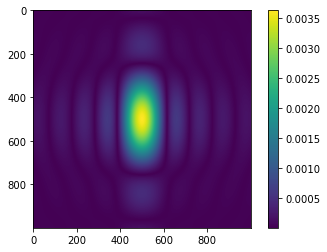

In [29]:
Mosys = OpticalSystem(layers)
psf = Mosys.propagate_mono(params_dict)
plt.imshow(psf**0.5)
plt.colorbar()
plt.show()